In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.utils.math_utils import get_fft_power

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [333]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

#! todo toremove the tof_1_v20 part
tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5", "tof_5_v20"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_3_v17,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,57.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,68.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,97.0,107.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,151.0,113.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,207.0,121.0,192.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,219.0,93.0,46.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,216.0,82.0,50.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,208.0,83.0,53.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,210.0,91.0,48.0,1,30,0,1,186.0,55,30.0


In [334]:
# Clean DataFrame
def get_counts(df) -> pd.DataFrame:
    return df.groupby("sequence_id")["sequence_counter"].max() - df.groupby("sequence_id")["sequence_counter"].min() + 1


def clean_df(df: pd.DataFrame):
    non_target_gestures = df[df["sequence_type"] == "Non-Target"]["gesture"].unique()
    target_gestures = df[df["sequence_type"] == "Target"]["gesture"].unique()

    filtered_df = df[df["phase"] == "Gesture"]
    filtered_df.loc[filtered_df["sequence_type"] == "Non-Target", "gesture"] = non_target_gestures[0]

    # drop na rotation
    bad_seq_id = df[df["rot_w"].isnull()]["sequence_id"].unique()
    bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
    filtered_df = filtered_df[~bad_seq_mask]
    
    #! TODO TOREMOVE
    for i in range(1, 6):
        bad_seq_id = df[df[f"thm_{i}"].isnull()]["sequence_id"].unique()
        bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
        filtered_df = filtered_df[~bad_seq_mask]
    # end toremove

    # drop outliers in terms of count
    gesture_counts = get_counts(filtered_df)
    valid_mask = (gesture_counts > 20) & (gesture_counts <= 50)
    valid_idx = gesture_counts[valid_mask].index

    filtered_df = filtered_df[filtered_df["sequence_id"].isin(valid_idx)]

    return filtered_df, target_gestures


def normalize_sequence_count(df: pd.DataFrame, group_col: str, max_count: int, seq_counter_col: str = "sequence_counter") -> pd.DataFrame:
    """
    Adds gesture_counter_length with a value of the length of the elmeents of teh array
    it gets maximum + 1, so it is the execlusive end
    """
    out_groups = []

    for _, group in df.groupby(group_col, sort=False):
        g = group.copy()
        # compute length for this group
        group_count = g[seq_counter_col].max() - g[seq_counter_col].min() + 1
        needed = max_count - group_count

        # broadcast the group length to existing rows
        g["gesture_counter_length"] = group_count
        # g["is_original"] = 1

        if needed > 0:
            last = g.iloc[-1].copy()
            repeats = pd.DataFrame([last] * needed)

            # continue the sequence_counter for appended rows
            start = int(last[seq_counter_col])
            repeats[seq_counter_col] = range(start + 1, start + 1 + needed)

            # ensure the appended rows also carry the same group length
            repeats["gesture_counter_length"] = group_count
            # repeats["is_original"] = 0

            g = pd.concat([g, repeats], ignore_index=True)

        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)

In [335]:
filtered_df, target_gestures = clean_df(full_df)

max_global_count = get_counts(filtered_df).max()
filtered_df = normalize_sequence_count(
    filtered_df,
    "sequence_id",
    max_global_count,
)

filtered_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm,gesture_counter_length
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,-1.0,-1.0,0,12,1,1,163.0,52,24.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376245,SEQ_065531_000052,Non-Target,SEQ_065531,66,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,88.0,48.0,1,30,0,1,186.0,55,30.0,32
376246,SEQ_065531_000052,Non-Target,SEQ_065531,67,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,88.0,48.0,1,30,0,1,186.0,55,30.0,32
376247,SEQ_065531_000052,Non-Target,SEQ_065531,68,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,88.0,48.0,1,30,0,1,186.0,55,30.0,32
376248,SEQ_065531_000052,Non-Target,SEQ_065531,69,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,88.0,48.0,1,30,0,1,186.0,55,30.0,32


In [336]:
def rotation_feature_engineer(df: pd.DataFrame):
    quat = df[["rot_w", "rot_x", "rot_y", "rot_z"]]
    rotation_object = Rotation.from_quat(quat)
    rotation_vectors = rotation_object.as_rotvec()

    df["rotvec_x"] = rotation_vectors[:, 0]
    df["rotvec_y"] = rotation_vectors[:, 1]
    df["rotvec_z"] = rotation_vectors[:, 2]
    df["rot_angle"] = np.linalg.norm(rotation_vectors, axis=1)

    df["rotvec_y_diff"] = df.groupby("sequence_id")["rotvec_y"].transform(lambda x: x.diff().fillna(0))
    df["rotvec_x_diff"] = df.groupby("sequence_id")["rotvec_x"].transform(lambda x: x.diff().fillna(0))
    df["rotvec_z_diff"] = df.groupby("sequence_id")["rotvec_z"].transform(lambda x: x.diff().fillna(0))
    df["angular_mag"] = np.linalg.norm([df["rotvec_x_diff"], df["rotvec_y_diff"], df["rotvec_z_diff"]], axis=0)
    
    return df

def accelrometer_feature_engineer(df: pd.DataFrame):
    cols_of_interest = ["acc_x", "acc_y", "acc_z"]

    for col in cols_of_interest:
        df[f"fft_{col}"] = df.groupby("sequence_id")[col].transform(get_fft_power)

    df["acc_mag"] = np.linalg.norm([df["acc_x"], df["acc_y"], df["acc_z"]], axis=0)
    
    return df

filtered_df = rotation_feature_engineer(filtered_df)
filtered_df = accelrometer_feature_engineer (filtered_df)

filtered_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_z,rot_angle,rotvec_y_diff,rotvec_x_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.927352,1.235290,0.000000,0.000000,0.000000,0.000000,60942.0,41530.0,22004.0,9.924192
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,0.898660,1.210973,-0.009322,-0.003831,-0.028692,0.030410,4.0,52.0,113.0,10.113299
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.924279,1.214547,-0.002796,0.032691,0.025619,0.041628,77.0,67.0,207.0,10.536305
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,0.970921,1.261463,0.061592,0.050705,0.046642,0.092412,69.0,17.0,56.0,9.782531
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,0.977821,1.270877,0.017812,0.014674,0.006900,0.024087,31.0,0.0,96.0,9.925453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376245,SEQ_065531_000052,Non-Target,SEQ_065531,66,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,1.282122,2.796136,0.000000,0.000000,0.000000,0.000000,5.0,0.0,8.0,10.574324
376246,SEQ_065531_000052,Non-Target,SEQ_065531,67,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,1.282122,2.796136,0.000000,0.000000,0.000000,0.000000,38.0,6.0,18.0,10.574324
376247,SEQ_065531_000052,Non-Target,SEQ_065531,68,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,1.282122,2.796136,0.000000,0.000000,0.000000,0.000000,1.0,0.0,9.0,10.574324
376248,SEQ_065531_000052,Non-Target,SEQ_065531,69,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,1.282122,2.796136,0.000000,0.000000,0.000000,0.000000,26.0,6.0,14.0,10.574324


In [402]:
target_df = filtered_df["gesture"]
encoder = load_encoder(encoder_path, target_df)  # type: ignore

features_of_interest = [
    "gesture_counter_length",
    "acc_x",
    "acc_y",
    "acc_z",
    "fft_acc_x",
    "fft_acc_y",
    "fft_acc_z",
    # "acc_mag",  # model dropped with this
    #
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_mag",
    
    # Non IMU readings
    "tof_1_v20", 
    # "thm_1",
    "thm_2",
    # "thm_3",
    "thm_4",
    "thm_5",
]

sequence_groups = filtered_df.groupby("sequence_id")

feature_np = np.array([group for _, group in sequence_groups[features_of_interest]], dtype=np.float32)
target_np = np.array([encoder.transform(group.unique()) for _, group in sequence_groups["gesture"]])

In [403]:
# encoder

target_tensor = torch.tensor(target_np, dtype=torch.long).squeeze(1)
target_gestures_encoded = torch.tensor(encoder.transform(target_gestures))

feature_tensor = torch.tensor(feature_np)
feature_tensor.shape, target_tensor.shape

(torch.Size([7525, 50, 16]), torch.Size([7525]))

In [404]:
class SimpleModel(nn.Module):
    def __init__(self, n_input, n_classes):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_input, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, n_classes),
        )

    def forward(self, x: torch.Tensor):
        y_pred = self.fc(x)

        return y_pred

In [405]:
n_input = np.prod(feature_tensor.shape[1:])
features_count = feature_tensor.shape[-1]

In [406]:
batch_size = 64
n_epochs = 100
n_splits = 5

gkf = GroupKFold(n_splits)

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []

test_subjects = []
folds_score = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=feature_tensor, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = feature_tensor[train_indices], target_tensor[train_indices]
    X_test, y_test = feature_tensor[test_indices], target_tensor[test_indices]
    
    mean = X_train.view(-1, X_train.size(-1)).mean(dim=0)   # shape (F,)
    std  = X_train.view(-1, X_train.size(-1)).std(dim=0) + 1e-8  # shape (F,)

    # Normalize
    X_train = (X_train - mean[None, None, :]) / std[None, None, :]
    X_test  = (X_test  - mean[None, None, :]) / std[None, None, :]
    
    X_train_arr.append(X_train.numpy())
    X_test_arr.append(X_test.numpy())
    y_train_arr.append(y_train.numpy())
    y_test_arr.append(y_test.numpy())
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    
    model = SimpleModel(n_input, len(encoder.classes_)).to(device)
    
    model.train()
    train_model(model, dataloader_train, n_epochs, True)

    model.eval()
    score_dashboard = evaulate_model(model, X_test, y_test, target_gestures_encoded, encoder)
    folds_score.append(score_dashboard)

0 - loss_avg: 1.5464419339832507
20 - loss_avg: 0.5856977660405008
40 - loss_avg: 0.35162540454613533
60 - loss_avg: 0.24312917833265504
80 - loss_avg: 0.15227100978556432
0 - loss_avg: 1.5573279744700381
20 - loss_avg: 0.57827992909833
40 - loss_avg: 0.3830940717145016
60 - loss_avg: 0.23109877242853766
80 - loss_avg: 0.17821615871630217
0 - loss_avg: 1.5109342298609145
20 - loss_avg: 0.57687279867365
40 - loss_avg: 0.36732980941838406
60 - loss_avg: 0.2287100184154003
80 - loss_avg: 0.1643408605075897
0 - loss_avg: 1.5332139679726133
20 - loss_avg: 0.5830436453540274
40 - loss_avg: 0.3346974784706501
60 - loss_avg: 0.22760333112896758
80 - loss_avg: 0.14489310286305052
0 - loss_avg: 1.5626645778354846
20 - loss_avg: 0.5788840789543955
40 - loss_avg: 0.35166888252684947
60 - loss_avg: 0.2431861096306851
80 - loss_avg: 0.1825306985331209


macro: 0.41, binary: 0.91, competition: 0.66


,precision,recall,f1-score,support
Above ear - pull hair,0.526718,0.579832,0.552000,119.000000
Cheek - pinch skin,0.291667,0.237288,0.261682,118.000000
Eyebrow - pull hair,0.266667,0.271186,0.268908,118.000000
Eyelash - pull hair,0.346667,0.222222,0.270833,117.000000
Forehead - pull hairline,0.405941,0.341667,0.371041,120.000000
Forehead - scratch,0.477124,0.608333,0.534799,120.000000
Neck - pinch skin,0.279221,0.361345,0.315018,119.000000
Neck - scratch,0.314286,0.275000,0.293333,120.000000
Write name on leg,0.837088,0.860963,0.848858,561.000000
accuracy,0.547619,0.547619,0.547619,0.547619


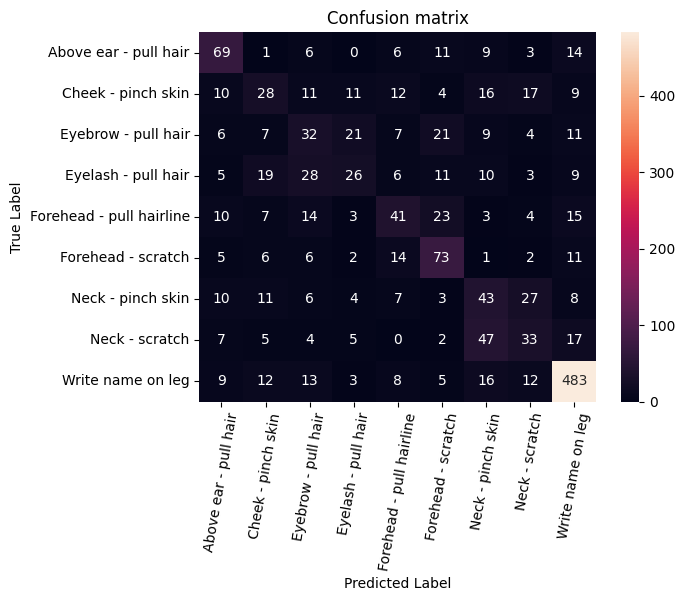

In [408]:
# fold = get_avg_fold(folds_score)
fold = folds_score[2]

macro = fold["f1_macro"]
binary = fold["f1_binary"]

competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.2f}, binary: {binary:.2f}, competition: {competition_eval:.2f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

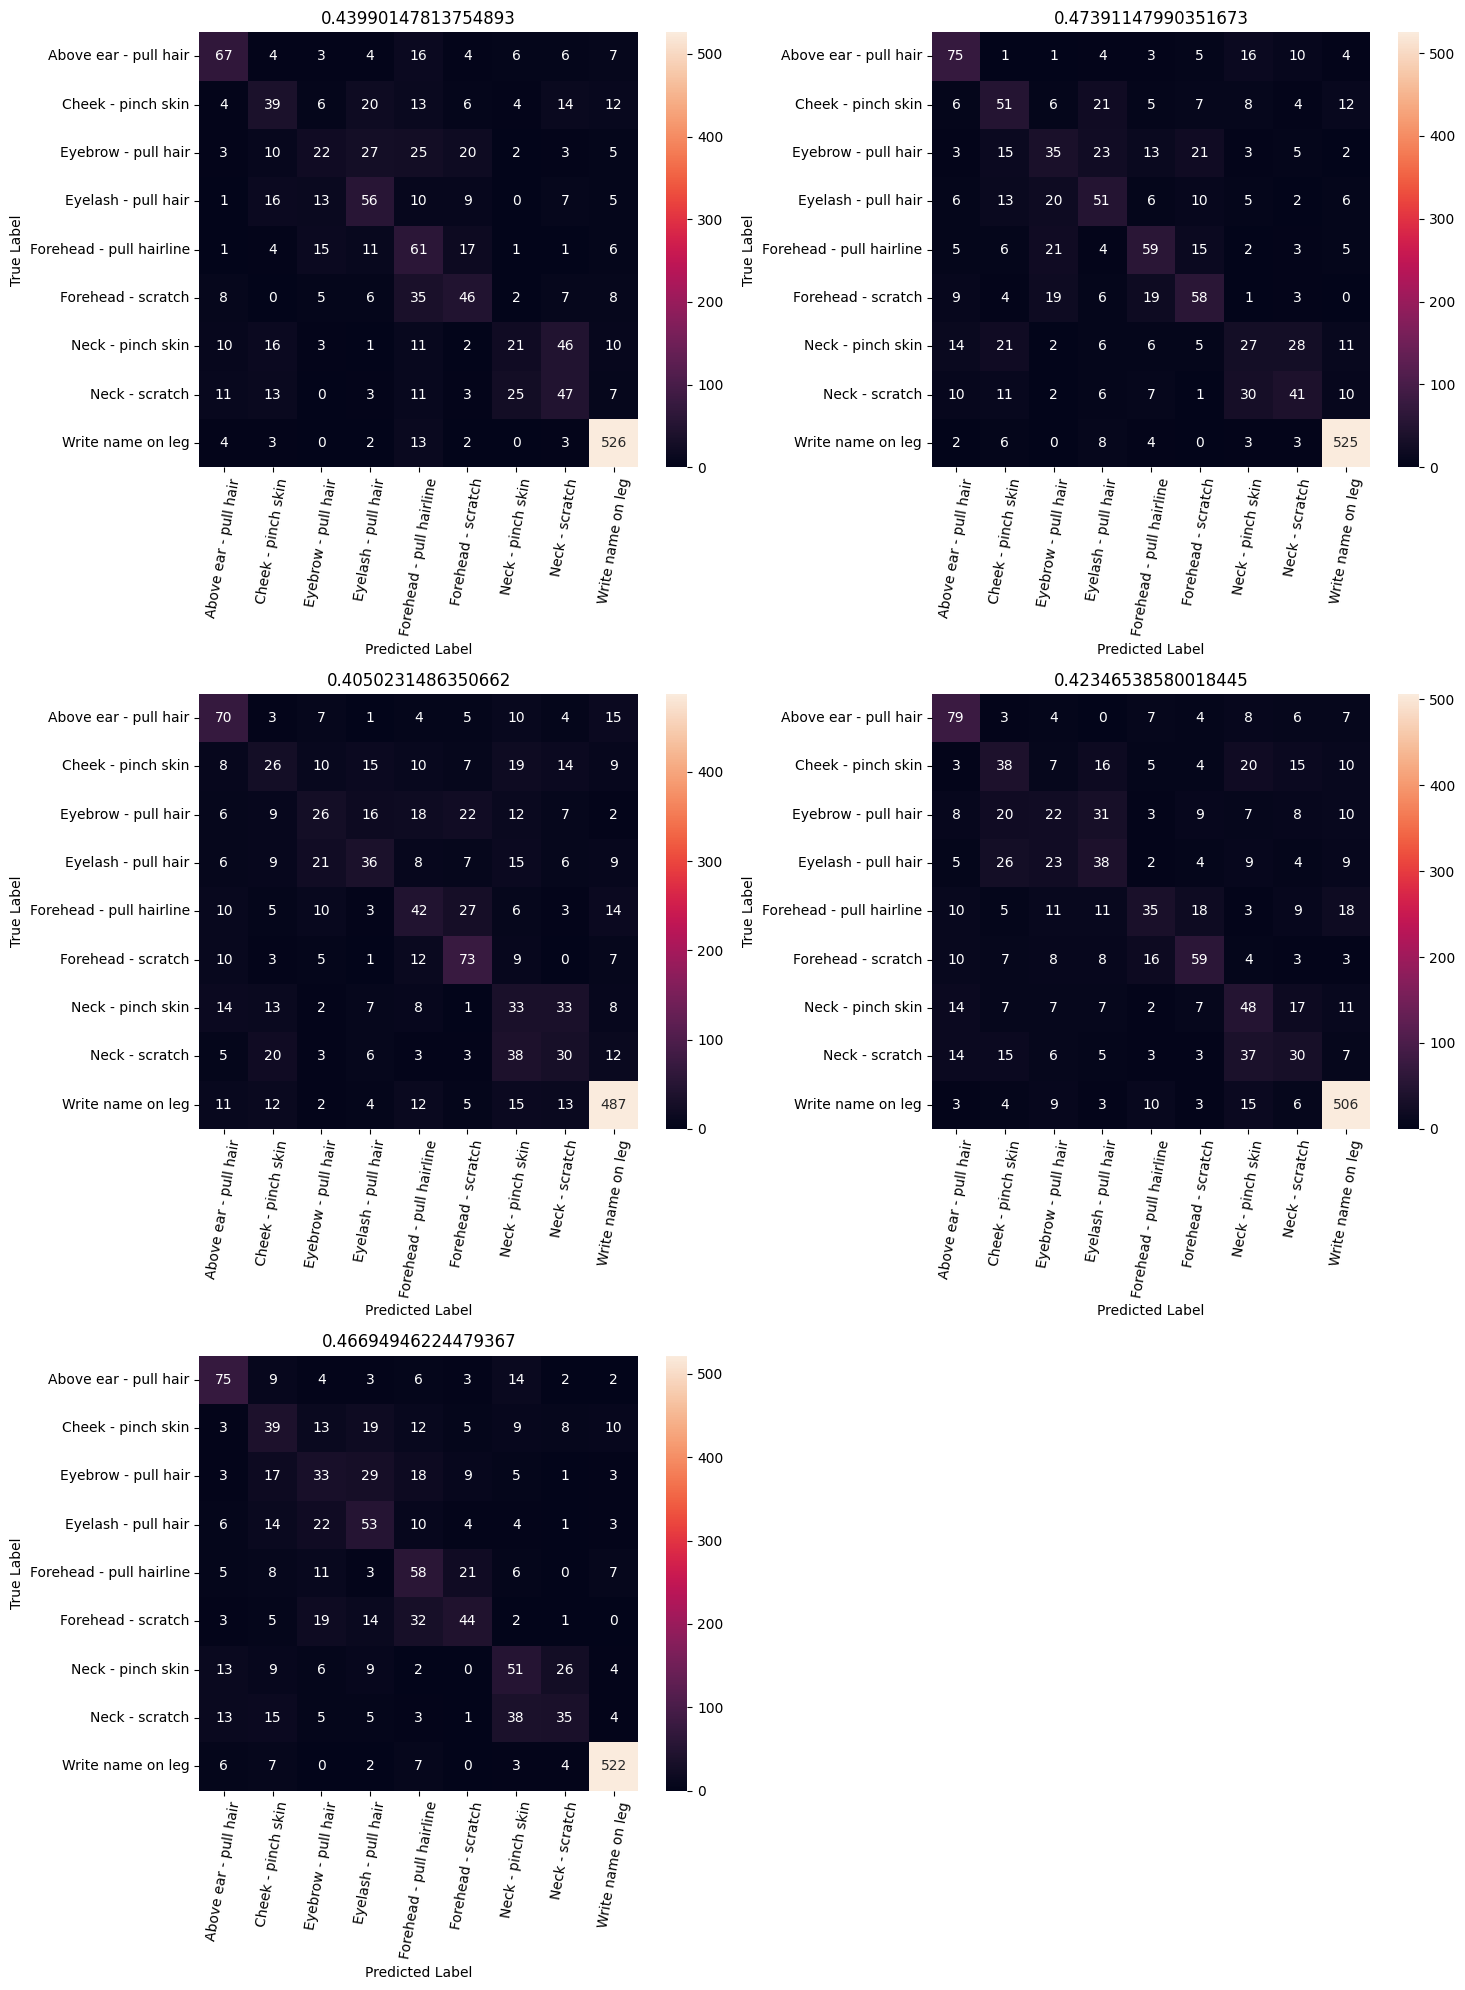

In [366]:
plt.figure(figsize=(15, 20))
for i, fold in enumerate(folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

good subjects: ['SUBJ_003328' 'SUBJ_004117' 'SUBJ_017499' 'SUBJ_020948' 'SUBJ_027671'
 'SUBJ_030676' 'SUBJ_036450' 'SUBJ_040282' 'SUBJ_040733' 'SUBJ_041770'
 'SUBJ_047636' 'SUBJ_052342' 'SUBJ_053906' 'SUBJ_054811' 'SUBJ_056936'
 'SUBJ_058967']
bad subjects: ['SUBJ_008304' 'SUBJ_013623' 'SUBJ_019262' 'SUBJ_019756' 'SUBJ_023739'
 'SUBJ_024137' 'SUBJ_026460' 'SUBJ_032233' 'SUBJ_038277' 'SUBJ_040106'
 'SUBJ_042779' 'SUBJ_042794' 'SUBJ_045235' 'SUBJ_050642' 'SUBJ_059960']


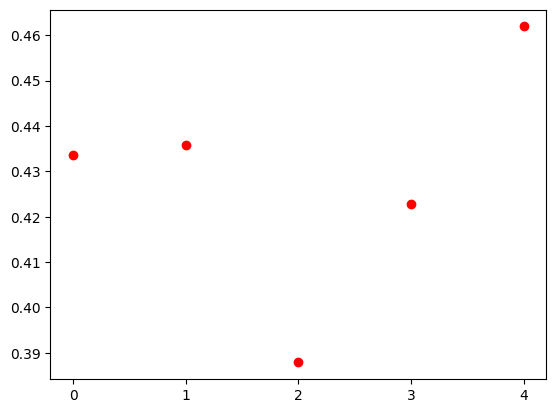

In [359]:
macros = [f["f1_macro"] for f in folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

bad_idx = 2
good_idx = 4

print(f'good subjects: {test_subjects[good_idx]}')
print(f'bad subjects: {test_subjects[bad_idx]}')

KeyboardInterrupt: 

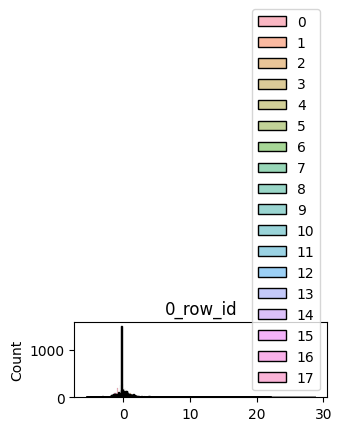

In [275]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

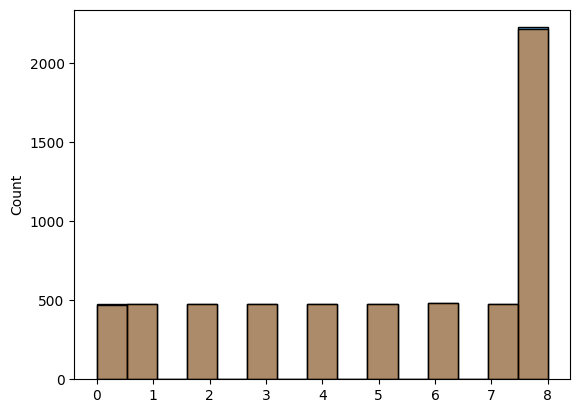

In [276]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
